In [3]:
from xml.etree import ElementTree
from pathlib import Path
import pandas as pd
from collections import deque, Counter

In [106]:
def get_inner_names(root):
    column_names = []
    queue = deque([root])
    
    while queue:
        childs, child_names = get_childs(queue.popleft())
        queue.extend(childs)
        column_names.extend(child_names)
    
    return column_names

def get_childs(root):
    names = [child.tag for child in root]
    return list(root), names

def convert_xml_to_df(dataset_path):
    dataset_path = Path(dataset_path)
    dataset = []
    
    for xml_path in dataset_path.rglob("*.xml"):
        xml_tree = ElementTree.parse(xml_path)
        
        root = xml_tree.getroot()
        dataset_elem = {}
        
        column_names = get_inner_names(root)
        cnt = Counter(column_names)
        num_objs = cnt['object']
        
        uniqie_column_names = list(set(column_names))
        obj_names = get_inner_names(root.find("object"))
        
        for name in set(uniqie_column_names)-set(obj_names):
                dataset_elem[name] = list(root.iter(name))[0].text
        
        dataset_elems = [dataset_elem.copy() for i in range(num_objs)]
        for idx, obj in enumerate(root.iter("object")):
            for name in obj_names:
                dataset_elems[idx][name] = list(obj.iter(name))[0].text
                
        dataset.extend(dataset_elems)
        
    dataset = pd.DataFrame(dataset)
    return dataset

In [142]:
data = convert_xml_to_df("../data")
for column_name in ['xmin', 'xmax', 'ymin', 'ymax', 'width', 'depth', 'height', 'segmented', 'truncated', 'difficult']:
    data[column_name] = data[column_name].astype(int)
data.head()

,depth,size,database,height,object,segmented,path,folder,source,width,filename,name,pose,truncated,difficult,bndbox,xmin,ymin,xmax,ymax
0,3,\n\t\t,Unknown,168,\n\t\t,0,validation/images/img (22).jpg,images,\n\t\t,300,img (22).jpg,fire,Unspecified,0,0,\n\t\t\t,45,130,109,157
1,3,\n\t\t,Unknown,168,\n\t\t,0,validation/images/img (22).jpg,images,\n\t\t,300,img (22).jpg,fire,Unspecified,0,0,\n\t\t\t,176,51,263,99
2,3,\n\t\t,Unknown,168,\n\t\t,0,validation/images/img (22).jpg,images,\n\t\t,300,img (22).jpg,fire,Unspecified,1,0,\n\t\t\t,284,92,300,115
3,3,\n\t\t,Unknown,168,\n\t\t,0,validation/images/img (22).jpg,images,\n\t\t,300,img (22).jpg,fire,Unspecified,0,0,\n\t\t\t,239,131,284,152
4,3,\n\t\t,Unknown,275,\n\t\t,0,validation/images/small (29).jpg,images,\n\t\t,183,small (29).jpg,fire,Unspecified,0,0,\n\t\t\t,80,24,106,103


In [130]:
data['database'].unique()

array(['Unknown'], dtype=object)

In [131]:
data['segmented'].unique()

array([0])

[0 1]
0    691
1     10
Name: truncated, dtype: int64


<AxesSubplot:>

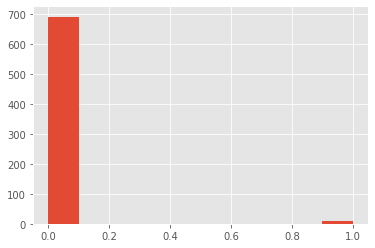

In [132]:
print(data['truncated'].unique())
print(data['truncated'].value_counts())
data['truncated'].hist()

In [133]:
data['difficult'].unique()

array([0])

In [134]:
data['name'].unique()

array(['fire'], dtype=object)

In [135]:
data['pose'].unique()

array(['Unspecified'], dtype=object)

In [136]:
print(f"Max values w={data['width'].max()}, h={data['height'].max()}, d={data['depth'].max()}")
print(f"Min values w={data['width'].min()}, h={data['height'].min()}, d={data['depth'].min()}")

Max values w=367, h=303, d=3
Min values w=156, h=135, d=3


<AxesSubplot:>

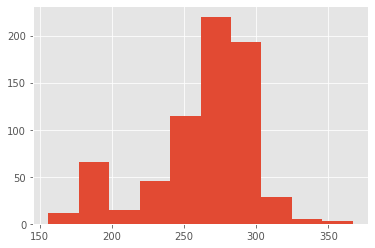

In [143]:
data['width'].hist()

<AxesSubplot:>

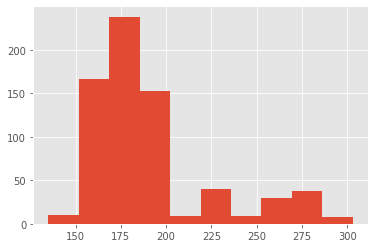

In [144]:
data['height'].hist()

In [145]:
data['y'] = data.apply(lambda row: row['ymax']-row['ymin'], axis=1)
data['x'] = data.apply(lambda row: row['xmax']-row['xmin'], axis=1)
data['taken_area'] = data.apply(lambda row: (row['x']*row['y'])/(row['width']*row['height']), axis=1)

In [146]:
data.head()

,depth,size,database,height,object,segmented,path,folder,source,width,...,truncated,difficult,bndbox,xmin,ymin,xmax,ymax,y,x,taken_area
0,3,\n\t\t,Unknown,168,\n\t\t,0,validation/images/img (22).jpg,images,\n\t\t,300,...,0,0,\n\t\t\t,45,130,109,157,27,64,0.034286
1,3,\n\t\t,Unknown,168,\n\t\t,0,validation/images/img (22).jpg,images,\n\t\t,300,...,0,0,\n\t\t\t,176,51,263,99,48,87,0.082857
2,3,\n\t\t,Unknown,168,\n\t\t,0,validation/images/img (22).jpg,images,\n\t\t,300,...,1,0,\n\t\t\t,284,92,300,115,23,16,0.007302
3,3,\n\t\t,Unknown,168,\n\t\t,0,validation/images/img (22).jpg,images,\n\t\t,300,...,0,0,\n\t\t\t,239,131,284,152,21,45,0.018750
4,3,\n\t\t,Unknown,275,\n\t\t,0,validation/images/small (29).jpg,images,\n\t\t,183,...,0,0,\n\t\t\t,80,24,106,103,79,26,0.040815


<AxesSubplot:>

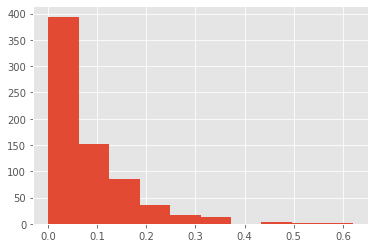

In [147]:
data['taken_area'].hist()